In [298]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:0


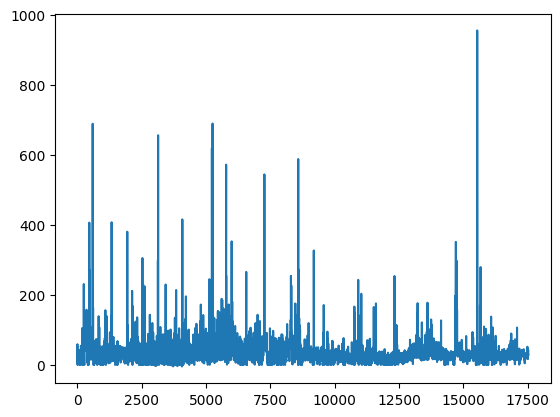

In [299]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_excel("C:/Users/Patrick/Documents/projects/EnergyForecasting/dta/final_dta.xlsx")
timeseries = df[["price"]].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [300]:
# Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
# train-test split for time series

train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train = timeseries[:train_size].reshape(-1, 1)
test = timeseries[train_size:].reshape(-1, 1)
scaler = StandardScaler()
train = scaler.fit_transform(train).flatten().tolist()
test = scaler.transform(test).flatten().tolist()



In [301]:
# Sequence Data Preparation
SEQUENCE_SIZE = 11

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, test)

In [302]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [303]:
# Model definition
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

In [304]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming the model, train_loader, test_loader, and device are already defined.

# Train the model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    val_rmse = np.sqrt(val_loss)  # Calculate RMSE
    scheduler.step(val_rmse)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation RMSE: {val_rmse:.4f}")

c:\Users\Patrick\Documents\projects\ml\venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation RMSE: 0.4981
Epoch 2/1000, Validation RMSE: 0.4935
Epoch 3/1000, Validation RMSE: 0.4946
Epoch 4/1000, Validation RMSE: 0.4933
Epoch 5/1000, Validation RMSE: 0.4911
Epoch 6/1000, Validation RMSE: 0.4919
Epoch 7/1000, Validation RMSE: 0.4921
Epoch 8/1000, Validation RMSE: 0.4910
Epoch 9/1000, Validation RMSE: 0.4921
Epoch 10/1000, Validation RMSE: 0.4909
Epoch 11/1000, Validation RMSE: 0.4906
Epoch 12/1000, Validation RMSE: 0.4905
Epoch 13/1000, Validation RMSE: 0.4906
Epoch 14/1000, Validation RMSE: 0.4898
Epoch 15/1000, Validation RMSE: 0.4895
Epoch 16/1000, Validation RMSE: 0.4886
Epoch 17/1000, Validation RMSE: 0.4897
Epoch 18/1000, Validation RMSE: 0.4894
Epoch 19/1000, Validation RMSE: 0.4899
Epoch 20/1000, Validation RMSE: 0.4898
Epoch 21/1000, Validation RMSE: 0.4875
Epoch 22/1000, Validation RMSE: 0.4888
Epoch 23/1000, Validation RMSE: 0.4881
Epoch 24/1000, Validation RMSE: 0.4891
Epoch 25/1000, Validation RMSE: 0.4876
Epoch 26/1000, Validation RMSE: 0.

In [306]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

lstm_forecast = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
realized_values = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
rmse = np.sqrt(((lstm_forecast - realized_values) ** 2).mean())

print(f"RMSE: {rmse:.4f}")



RMSE: 16.5288


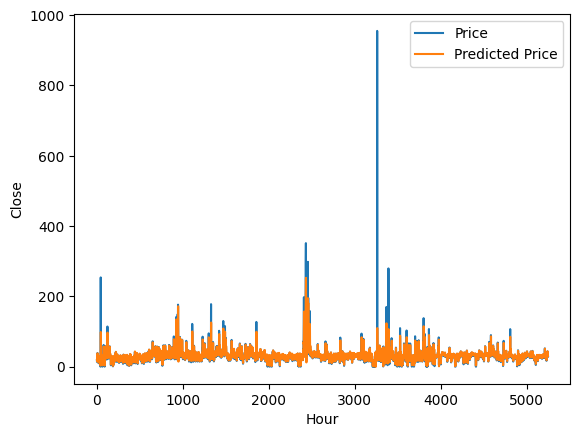

In [309]:
plt.plot(realized_values, label='Price')
plt.plot(lstm_forecast, label='Predicted Price')
plt.xlabel('Hour')
plt.ylabel('Close')
plt.legend()
plt.show()

In [308]:
rmse1 = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))

lstm_forecast = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
realized_values = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

print(f"RMSE: {rmse1:.4f}")

RMSE: 16.5288
